# Embedding of ontology concepts: Cell Type usecase

We create the following embeddings:

- __TTypes__: TType ontology from Allen dendrogram (see https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-10x) and mean gene expression profiles per type
- __MTypes__: Materialized MType ontology (see https://bbp.epfl.ch/nexus/webprotege/#projects/f9354eaa-f69b-4f0d-949a-0c64fdd9d995/edit/Classes) and morpho metrics computed with NeuroM for annotated SSCX morphologies
   

In [176]:
import json

import pandas as pd
import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

import rdflib
from rdflib import RDF, RDFS, OWL

from bluegraph import PandasPGFrame
from bluegraph.backends.networkx import pgframe_to_networkx
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder
from bluegraph.downstream.utils import transform_to_2d, plot_2d

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## Helpers

In [136]:
def is_nan(el):
    try:
        if np.isnan(el):
            return True
    except:
        pass
    return False


def autocomplete_types_from_children(frame, feature_column):
    graph = pgframe_to_networkx(frame)
    prev_nodes_to_process = set()
    while True:
        nodes_to_process = set()
        for n in frame.nodes():
            if is_nan(frame._nodes.loc[n, feature_column]):
                nodes_to_process.add(n)

        if len(nodes_to_process) == 0 or\
           (prev_nodes_to_process == nodes_to_process):
            break

        for n in nodes_to_process:
            all_children = True
            children_vectors = []
            for child, n in graph.in_edges(n):

                if child in frame.nodes():
                    if is_nan(frame._nodes.loc[child, feature_column]):
                        all_childern = False
                        break
                    children_vectors.append(frame._nodes.loc[child, feature_column])

            if all_children:
                frame._nodes.at[n, feature_column] = np.mean(
                    children_vectors, axis=0).tolist()
                
        prev_nodes_to_process = nodes_to_process

## Embedding of TTypes

Read the datasets.

__TODO__: now these datasets can be read from Nexus https://bbp.epfl.ch/nexus/web/admin/bbp/aibs

In [137]:
means = pd.read_csv("data/trimmed_means.csv").set_index("feature")

In [138]:
with open("data/dend.json", "r") as f:
    hierarchy = json.load(f)

Extract nodes and edges from the dendrogram (hierarchy of TTypes as it is provided by Allen)

In [139]:
edges = set()
nodes = {}
def extract_data(hierarchy, father=None):
    if "children" in hierarchy:
        for child in hierarchy["children"]:
            if "node_attributes" in child:
                attrs = child["node_attributes"][0]
            else:
                attrs = child["leaf_attributes"][0]
            nodes[attrs["cell_set_accession"]] = attrs
            extract_data(child, attrs["cell_set_accession"])
            if father:
                edges.add((attrs["cell_set_accession"], father))
extract_data(hierarchy)

Create a matrix of gene expressions for each type

In [140]:
expression_matrix = means.T.values

Apply dimensionality reduction on the matrix (greatly simplifies the similarity search without loosing too much information).

In [141]:
pca = PCA(n_components=256)
reduced_expression_matrix = pca.fit_transform(expression_matrix)

In [142]:
sum(pca.explained_variance_ratio_)

0.9852168400046978

Create a PandasPGFrame

In [143]:
node_df = pd.DataFrame(nodes.values()).rename(
    columns={"cell_set_accession": "@id"})

In [144]:
node_df = pd.DataFrame(nodes.values()).rename(
    columns={"cell_set_accession": "@id"})
node_vectors = {}
for i, c in enumerate(means.columns):
    node_vectors[c] = reduced_expression_matrix[i, :].tolist()
node_vectors = pd.DataFrame(
    node_vectors.items(), columns=["cell_set_alias", "features"])
node_df = node_df.merge(node_vectors, on="cell_set_alias", how="left").set_index("@id")

In [145]:
edge_df = pd.DataFrame(edges, columns=["@source_id", "@target_id"]).set_index(["@source_id", "@target_id"])
edge_df["@type"] = "IS_SUBCLASS_OF"
frame = PandasPGFrame.from_frames(node_df, edge_df)
for c in frame._nodes.columns:
    frame.node_prop_as_category(c)

Remove intermediate nodes from the created graph that do not represent any 'labeled' cell types, but only unlabeled clusters of cells.

In [146]:
graph = pgframe_to_networkx(frame)

In [147]:
while True:
    edges_to_remove = set()
    edges_to_add = set()
    for n in graph.nodes():
        if frame._nodes.loc[n, "cell_set_alias"]:
            for _, t in graph.out_edges(n):
                father_alias = frame._nodes.loc[t, "cell_set_alias"]
                if not father_alias:
                    edges_to_remove.add((n, t))
                    for _, tt in graph.out_edges(t):
                        edges_to_add.add((n, tt))

    for s, t in edges_to_remove:
        graph.remove_edge(s, t)
    for s, t in edges_to_add:
        graph.add_edge(s, t)

    if not edges_to_remove and not edges_to_add:
        break

In [148]:
graph.remove_nodes_from(list(nx.isolates(graph)))
graph.remove_nodes_from([
    n for n in graph.nodes() if not frame._nodes.loc[n, "cell_set_alias"]
])
frame.remove_nodes([
    n for n in frame.nodes() if n not in graph.nodes()
])
frame.remove_edges([
    (s, t) for s, t in frame.edges() if (s, t) not in graph.edges()
])
new_edges = [
    (s, t) for s, t in graph.edges() if (s, t) not in frame.edges()
]
frame.add_edges(new_edges)

for s, t in new_edges:
    frame._edges.loc[(s, t), "@type"] = "IS_SUBCLASS_OF"

The ttype 'CS202106160_381' seem not to have any expression profile data in the current version of the dataset

In [149]:
frame.remove_nodes(["CS202106160_381"])
edges_to_remove = set()
for s, t in frame._edges.index:
    if s == "CS202106160_381":
        edges_to_remove.add((s, t))
    if t == "CS202106160_381":
        edges_to_remove.add((s, t))
frame.remove_edges(edges_to_remove)

At the moment only 'leaf' nodes have expression profiles assigned, we compute such profiles for non-leaf nodes by recursively averaging the profiles of thier children.

In [150]:
autocomplete_types_from_children(frame, "features")

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Fit an embedder

In [153]:
embedder = StellarGraphNodeEmbedder(
    "graphsage", length=5, number_of_walks=15,
    epochs=5, embedding_dimension=128,
    feature_vector_prop="features",
    random_walk_p=2, random_walk_q=0.2, biased=True)

In [154]:
embeddings = embedder.fit_model(frame)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Save embedding vectors and thier meta-data for visualization with https://projector.tensorflow.org/

In [155]:
a = np.array(embeddings["embedding"].tolist())
np.savetxt("data/graphsage_ttypes.tsv", a, delimiter="\t")
frame._nodes[["cell_set_alias"]].reset_index()[
    ["cell_set_alias", "@id"]].to_csv("data/ttypes_meta.tsv", sep="\t")

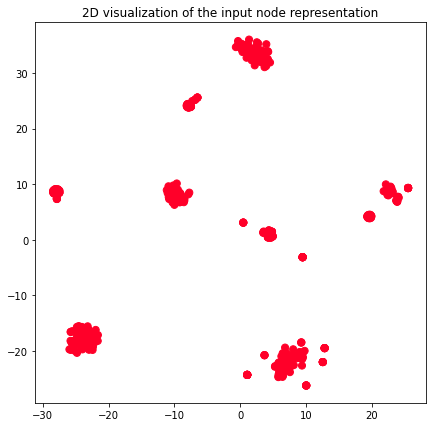

In [156]:
frame.add_node_properties(
    embeddings.rename(columns={"embedding": "graphsage"}))
embedding_2d = transform_to_2d(frame._nodes["graphsage"].tolist())
plot_2d(frame, vectors=embedding_2d)

## Embedding of MTypes

Load the data

In [159]:
with open("data/mtype_data_sscx.json", "r") as f:
    mtype_json = json.load(f)

In [164]:
# There is very little morphs with annotated apical dendrites, we skip for the moment
EXCLUDE_COMPARTMENTS = ["ApicalDendrite"]
EXCLUDE_STATISTICS = ["ApicalDendrite"]
STATISTICS_OF_INTEREST = ["mean", "standard_deviation"]

In [165]:
feature_records = []
for morpho in mtype_json:
    record = {}
    for ann in morpho["annotation"]:
        if "MType:Annotation" in ann["type"]:
            record["MType"] = ann["hasBody"]["label"]
        if "NeuronMorphologyFeatureAnnotation" in ann["type"]:
            compartment = ann["compartment"]
            if compartment not in EXCLUDE_COMPARTMENTS:
                for feature_ann in ann["hasBody"]:
                    feature_name = feature_ann["isMeasurementOf"]["label"].replace(" ", "_")
                    for el in feature_ann["series"]:
                        stat = el["statistics"].replace(" ", "_")
                        if stat in STATISTICS_OF_INTEREST:
                            record[f"{compartment}_{stat}_{feature_name}"] = el["value"]
    feature_records.append(record)

In [166]:
feature_df = pd.DataFrame(feature_records)

In [168]:
feature_df.head(3)

,MType,Axon_mean_Neurite_Max_Radial_Distance,Axon_standard_deviation_Neurite_Max_Radial_Distance,Axon_mean_Number_Of_Sections,Axon_standard_deviation_Number_Of_Sections,Axon_mean_Number_Of_Bifurcations,Axon_standard_deviation_Number_Of_Bifurcations,Axon_mean_Number_Of_Leaves,Axon_standard_deviation_Number_Of_Leaves,Axon_mean_Total_Length,...,NeuronMorphology_mean_Total_Area_Per_Neurite,NeuronMorphology_standard_deviation_Total_Area_Per_Neurite,NeuronMorphology_mean_Total_Volume_Per_Neurite,NeuronMorphology_standard_deviation_Total_Volume_Per_Neurite,NeuronMorphology_mean_Number_Of_Neurites,NeuronMorphology_standard_deviation_Number_Of_Neurites,Soma_mean_Soma_Surface_Area,Soma_standard_deviation_Soma_Surface_Area,Soma_mean_Soma_Radius,Soma_standard_deviation_Soma_Radius
0,L23_DBC,773.237122,773.237122,219.0,219.0,98.0,98.0,114.0,114.0,11417.310298,...,6030.143704,2934.483008,818.104014,261.266690,3.0,3.0,371.634057,371.634057,5.438171,5.438171
1,L1_HAC,984.625671,984.625671,333.0,333.0,166.0,166.0,167.0,167.0,13805.235600,...,2162.164353,2574.641844,149.578669,102.244077,4.0,4.0,550.023461,550.023461,6.615850,6.615850
2,L1_DAC,661.705017,661.705017,113.0,113.0,56.0,56.0,57.0,57.0,7377.857407,...,1245.910429,1811.931704,141.525359,114.577312,8.0,8.0,508.577054,508.577054,6.361704,6.361704


In [169]:
labels = feature_df["MType"].tolist()

Create a matrix of morphological features for each type

In [171]:
X = feature_df.drop(columns=["MType"]).values
X.shape

(805, 132)

Impute missing features with avg values

In [172]:
imputer = SimpleImputer()
imputed_X = imputer.fit_transform(X)

In [173]:
df = pd.DataFrame([
    {"label": l, "features": imputed_X[i, :]}
    for i, l in enumerate(labels)
])
type_features = df.groupby("label").aggregate(lambda x: np.mean(x, axis=0))

In [174]:
type_X = np.asarray(type_features["features"].tolist())

Explained variance for 2 dims: 0.9396792954480901


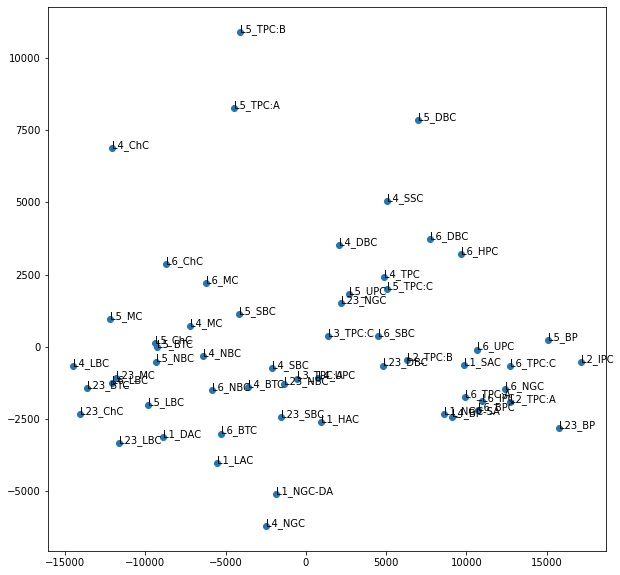

In [181]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(type_X)
print("Explained variance for 2 dims:", sum(pca.explained_variance_ratio_))
frame = PandasPGFrame()
frame.add_nodes(list(range(type_X.shape[0])))

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(features_2d[:, 0], features_2d[:, 1])

for i, txt in enumerate(type_features.index):
    ax.annotate(txt, (features_2d[i, 0], features_2d[i, 1]))

plt.show()

Scale features to look like Standard normal distribution, see https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling

In [182]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(type_X)

Load the hierarchy of MTypes

In [184]:
mtypes = rdflib.Graph()
mtypes.parse("data/mtypes.ttl", format="turtle")

<Graph identifier=N153ed8b60af64d888d3d77d517312e6b (<class 'rdflib.graph.Graph'>)>

In [185]:
mtype_hierarchy_nodes = []
mtype_hierarchy_edges = []
for s in mtypes.subjects(RDF.type, OWL.Class):
    mtype_hierarchy_nodes.append(mtypes.label(s).value)
    for o in mtypes.objects(s, RDFS.subClassOf):
        mtype_hierarchy_edges.append((mtypes.label(s).value, mtypes.label(o).value))

In [187]:
mtype_frame = PandasPGFrame()
mtype_frame.add_nodes(mtype_hierarchy_nodes)
mtype_frame.add_edges(mtype_hierarchy_edges)
mtype_frame._edges["@type"] = "IS_SUBCLASS_OF"

In [188]:
mtype_frame._nodes = mtype_frame._nodes.reset_index().merge(
    type_features.reset_index().rename(columns={"label": "@id"}),
    on="@id", how="left").set_index("@id")

At the moment only 'leaf' nodes have morph features assigned, we compute such profiles for non-leaf nodes by recursively averaging the features of thier children.

In [190]:
autocomplete_types_from_children(mtype_frame, "features")

/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/oshurko/opt/anaconda3/envs/bg/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [191]:
nodes_to_remove = list(mtype_frame._nodes["features"][mtype_frame._nodes["features"].apply(lambda x: is_nan(x))].index)

In [192]:
mtype_frame.remove_nodes(nodes_to_remove)

Fit an embedder

In [193]:
embedder = StellarGraphNodeEmbedder(
    "graphsage", length=5, number_of_walks=15,
    epochs=5, embedding_dimension=128,
    feature_vector_prop="features",
    random_walk_p=2, random_walk_q=0.2, biased=True)

In [194]:
embedding = embedder.fit_model(mtype_frame)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


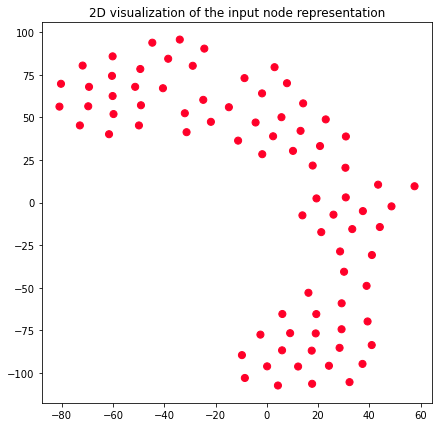

In [195]:
mtype_frame.add_node_properties(
    embedding.rename(columns={"embedding": "graphsage"}))
embedding_2d = transform_to_2d(mtype_frame._nodes["graphsage"].tolist())
plot_2d(mtype_frame, vectors=embedding_2d)

Save embedding vectors and thier meta-data for visualization with https://projector.tensorflow.org/

In [201]:
a = np.array(embedding["embedding"].tolist())
np.savetxt("data/graphsage_mtypes.tsv", a, delimiter="\t")
mtype_frame._nodes.reset_index()[["@id", "@id"]].to_csv(
    "data/mtypes_meta.tsv", sep="\t")